# Analisi del grafico a pettine

## Boring Setup

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats

# Cambiare directory per spostarsi nella cartella principale
import os
while not os.getcwd().endswith('Laboratorio_SiPM'):
    os.chdir('..')

import sys
sys.path.append('Config')
from lablib import *

### Funzioni utili

In [77]:
def crop_df(df: pd.DataFrame, N: int, thr = 0) -> pd.DataFrame:
    """
    Remove groups of consecutive numbers under the threshold from the DataFrame.
    """
    is_zero = df.iloc[:,1] <= thr
    group_id = (is_zero != is_zero.shift()).cumsum()
    removal_mask = pd.Series(False, index=df.index)
    for grp, group_indices in df.groupby(group_id).groups.items():
        if is_zero.loc[group_indices[0]] and len(group_indices) > N:
            removal_mask.loc[group_indices] = True
    return df[~removal_mask].copy()

def cut_df(df: pd.DataFrame, sec: tuple) -> pd.DataFrame:
    """
    Rimuove i dati al di fuori del range definito da sec.
    """
    return df[(df.iloc[:,0] >= sec[0]) & (df.iloc[:,0] <= sec[1])].copy()

def assign_errors(df: pd.DataFrame, lim = 30) -> np.ndarray:
    """
    Assegna un errore a ciascun valore in base al valore stesso.
    L'errore è considerato gaussiano se ci sono abbastanza eventi.
    Se il numero di eventi è minore di lim, va riconsiderato.
    """
    ys = list(df.iloc[:,1])
    tot = np.sum(ys)
    ers = np.zeros(len(df))

    i = 0
    for y in ys:
        if y > lim: # type: ignore
            ers[i] = np.sqrt(y) # type: ignore
        else:
            ers[i] = np.sqrt(lim) 
            #ers[i] = np.sqrt(y * y/tot * (1 - y/tot)) # FIXME
        i += 1

    return ers

def six_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, 
                           sig1, sig2, sig3, sig4, sig5, sig6,
                           scale1, scale2, scale3, scale4, scale5, scale6, 
                           bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
            scale2*stats.norm.pdf(x, mu2, sig2) +
            scale3*stats.norm.pdf(x, mu3, sig3) +
            scale4*stats.norm.pdf(x, mu4, sig4) +
            scale5*stats.norm.pdf(x, mu5, sig5) +
            scale6*stats.norm.pdf(x, mu6, sig6)) + \
            (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def eight_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8,
                            sig1, sig2, sig3, sig4, sig5, sig6, sig7, sig8,
                            scale1, scale2, scale3, scale4, scale5, scale6, scale7, scale8,
                            bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
                scale2*stats.norm.pdf(x, mu2, sig2) +
                scale3*stats.norm.pdf(x, mu3, sig3) +
                scale4*stats.norm.pdf(x, mu4, sig4) +
                scale5*stats.norm.pdf(x, mu5, sig5) +
                scale6*stats.norm.pdf(x, mu6, sig6) +
                scale7*stats.norm.pdf(x, mu7, sig7) +
                scale8*stats.norm.pdf(x, mu8, sig8)) + \
                (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def nine_gauss_plus_backgrd(x, mu1, mu2, mu3, mu4, mu5, mu6, mu7, mu8, mu9,
                            sig1, sig2, sig3, sig4, sig5, sig6, sig7, sig8, sig9,
                            scale1, scale2, scale3, scale4, scale5, scale6, scale7, scale8, scale9,
                            bkg_mu, bkg_sigma, bkg_scale):
    
    return (scale1*stats.norm.pdf(x, mu1, sig1) +
                scale2*stats.norm.pdf(x, mu2, sig2) +
                scale3*stats.norm.pdf(x, mu3, sig3) +
                scale4*stats.norm.pdf(x, mu4, sig4) +
                scale5*stats.norm.pdf(x, mu5, sig5) +
                scale6*stats.norm.pdf(x, mu6, sig6) +
                scale7*stats.norm.pdf(x, mu7, sig7) +
                scale8*stats.norm.pdf(x, mu8, sig8) +
                scale9*stats.norm.pdf(x, mu9, sig9)) + \
                (bkg_scale * stats.norm.pdf(x, bkg_mu, bkg_sigma))

def calculate_distances(vals: list[float], ers: list[float]) -> tuple[list[float], list[float]]:
    distances = []
    errors = []
    for i in range(len(vals)-1):
        distances.append(vals[i+1] - vals[i])

        # per calcolare l'errore della distanza, sommiamo gli errori in quadratura
        # che in questo caso corrisponde alla formula generale di propagazione degli errori
        errors.append(np.sqrt(ers[i]**2 + ers[i+1]**2))

    return distances, errors

def media_pesata(vals: list[float], ers: list[float]) -> tuple[float, float]:
    """
    Calcola la media pesata di una lista di valori con i rispettivi errori.
    Ritorna anche l'errore sulla media.
    """
    if len(vals) != len(ers):
        raise ValueError("Le liste dei valori e degli errori devono avere la stessa lunghezza.")
    
    weights = [1/(e**2) for e in ers]
    weighted_sum = sum(v * w for v, w in zip(vals, weights))
    total_weight = sum(weights)
    
    media = weighted_sum / total_weight if total_weight != 0 else 0.0
    errore = np.sqrt(1/total_weight) if total_weight != 0 else 0.0
    return media, errore

In [57]:
pettine53 = pd.read_csv('Dati/Parte 1/Gain_V/File csv (corretti)/pettine_dark_count_v53.csv')
pettine53_5 = pd.read_csv('Dati/Parte 1/Gain_V/File csv (corretti)/pettine_dark_count_v53_5.csv')
pettine54 = pd.read_csv('Dati/Parte 1/Gain_V/File csv (corretti)/pettine_dark_count_v54.csv')
pettine54_5 = pd.read_csv('Dati/Parte 1/Gain_V/File csv (corretti)/pettine_dark_count_v54_5.csv')
pettine55_5 = pd.read_csv('Dati/Parte 1/Gain_V/File csv (corretti)/pettine_dark_count_v55_5.csv')

thr_noise = 5
thr_sequence = 10
thr_errors = 30

p53 = crop_df(pettine53, thr_sequence, thr_noise) # valore di 5 arbitrario
p53_5 = crop_df(pettine53_5, thr_sequence, thr_noise)
p54 = crop_df(pettine54, thr_sequence, thr_noise)
p54_5 = crop_df(pettine54_5, thr_sequence, thr_noise)
p55_5 = crop_df(pettine55_5, thr_sequence, thr_noise)

p53_err = assign_errors(p53, thr_errors)
p53_5_err = assign_errors(p53_5, thr_errors)
p54_err = assign_errors(p54, thr_errors)
p54_5_err = assign_errors(p54_5, thr_errors)
p55_5_err = assign_errors(p55_5, thr_errors)

## Estrazione Dati

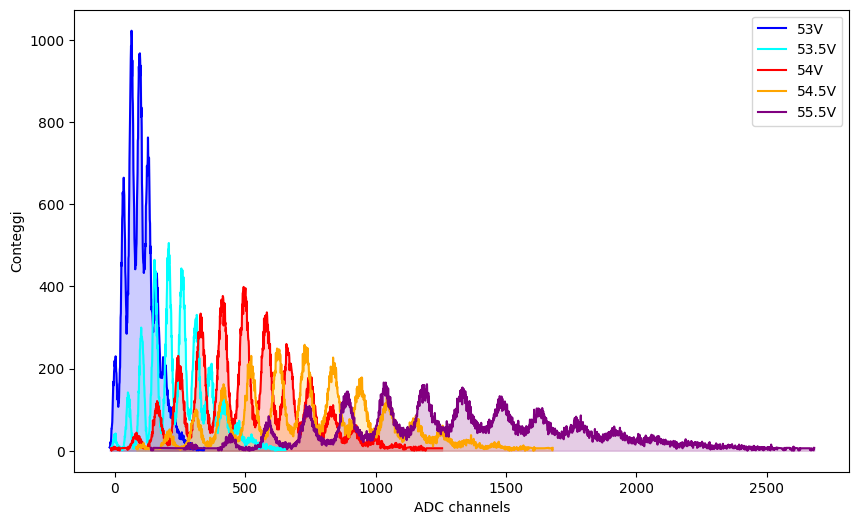

In [58]:
# commentare quelle che non servono

# plt.plot(p53.iloc[:,0], p53.iloc[:,1], label='pettine53', color='blue')
# plt.errorbar(p53.iloc[:,0], p53.iloc[:,1], yerr=p53_err, fmt='o', color='red', markersize=2, label='pettine53 error')

fig, ax = plt.subplots(figsize=(10, 6))

# Pettine 53V
ax.plot(p53.iloc[:,0], p53.iloc[:,1], label='53V', color='blue')
ax.fill_between(p53.iloc[:,0], p53.iloc[:,1], alpha=0.2, color='blue')

# Pettine 53.5V
ax.plot(p53_5.iloc[:,0], p53_5.iloc[:,1], label='53.5V', color='cyan')
ax.fill_between(p53_5.iloc[:,0], p53_5.iloc[:,1], alpha=0.2, color='cyan')

# Pettine 54V
ax.plot(p54.iloc[:,0], p54.iloc[:,1], label='54V', color='red')
ax.fill_between(p54.iloc[:,0], p54.iloc[:,1], alpha=0.2, color='red')

# Pettine 54.5V
ax.plot(p54_5.iloc[:,0], p54_5.iloc[:,1], label='54.5V', color='orange')
ax.fill_between(p54_5.iloc[:,0], p54_5.iloc[:,1], alpha=0.2, color='orange')

# Pettine 55.5V
ax.plot(p55_5.iloc[:,0], p55_5.iloc[:,1], label='55.5V', color='purple')
ax.fill_between(p55_5.iloc[:,0], p55_5.iloc[:,1], alpha=0.2, color='purple')

ax.set_xlabel('ADC channels')
ax.set_ylabel('Conteggi')
# ax.set_title('Conteggi in funzione dei canali ADC')
ax.legend()
plt.show()

### Analisi pettine 53 V

In [59]:
par53, val53, err53, pval53, dof53, qsq53, *other = LS_fit(p53.iloc[:,0], p53.iloc[:,1], p53_err, six_gauss_plus_backgrd, 
                                       mu1=0, mu2=30, mu3=60, mu4=90, mu5=130, mu6=160,
                                       scale1=1e3, scale2=1e4, scale3=1e4, scale4=1e4, scale5=1e4, scale6=5e3,
                                       sig1=10, sig2=10, sig3=10, sig4=10, sig5=10, sig6=10,
                                       bkg_mu=100, bkg_sigma=100, bkg_scale=10000,
                                       disp=0)

if 0: # solo per non farlo uscire sempre
    for i in range(len(par53)):
        print(f"parametro {par53[i]}: {val53[i]:.5g} ± {err53[i]:.5g}")

    print("----------")

    print(f"chi2 ridotto: {qsq53/dof53:.5g}")
    print(f"p-value: {pval53:.5g}")

In [83]:
peaks53 = val53[:6]
unc53 = val53[6:12]

# dist53, dist_err53 = calculate_distances(peaks53, err53) # usando errori del fit
dist53, dist_err53 = calculate_distances(peaks53, unc53) # usando errori delle gaussiane

print("Distanze pettine53:")
for i in range(len(dist53)):
    print(f" distanza {i+1}: {dist53[i]:.5g} ± {dist_err53[i]:.5g}")
print("----------")

dist53_mean = np.mean(dist53)
# dist53_std = np.sqrt(np.sum([i**2 for i in dist_err53])) / len(dist_err53) # errore medio
# dist53_std = np.sqrt(np.sum([i**2 for i in dist_err53]) / len(dist_err53)) # modificato per aumentare
dist53_mean, dist53_std = media_pesata(dist53, dist_err53) # usando la media pesata

print(f"Distanza media pettine 53v: {dist53_mean:.5g} ± {dist53_std:.5g}")

Distanze pettine53:
 distanza 1: 31.396 ± 10.794
 distanza 2: 31.163 ± 11.54
 distanza 3: 31.514 ± 11.878
 distanza 4: 31.779 ± 11.685
 distanza 5: 32.393 ± 10.328
----------
Distanza media pettine 53v: 31.678 ± 5.0076


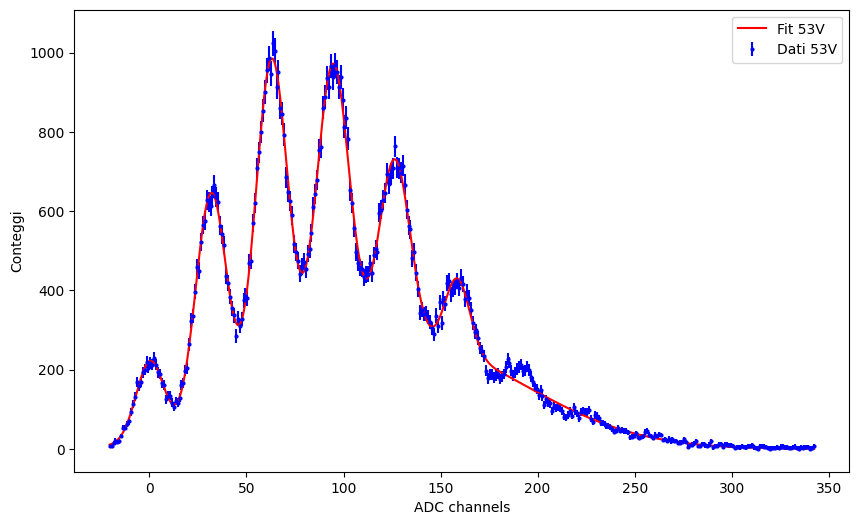

In [87]:
fig, ax = plt.subplots(figsize=(10, 6))

# Dati sperimentali con errore
ax.errorbar(p53.iloc[:,0], p53.iloc[:,1], yerr=p53_err, fmt='o', color='blue', markersize=2, label='Dati 53V')

# Curva del fit
x_fit = np.linspace(p53.iloc[:,0].min(), p53.iloc[:,0].max(), 1000)
y_fit = six_gauss_plus_backgrd(x_fit, *val53)
ax.plot(x_fit, y_fit, color='red', label='Fit 53V')

ax.set_xlabel('ADC channels')
ax.set_ylabel('Conteggi')
ax.legend()
plt.show()

### Analisi Pettine 53.5 V

In [61]:
par53_5, val53_5, err53_5, pval53_5, dof53_5, qsq53_5, *other = LS_fit(p53_5.iloc[:,0], p53_5.iloc[:,1], p53_5_err, eight_gauss_plus_backgrd,
                                                                        mu1=50, mu2=100, mu3=150, mu4=200, 
                                                                        mu5=250, mu6=330, mu7=380, mu8=430,
                                                                        
                                                                        scale1=1e4, scale2=1e4, scale3=1e4, scale4=1e4, 
                                                                        scale5=1e4, scale6=1e4, scale7=1e3, scale8=1e3,

                                                                        sig1=10, sig2=10, sig3=10, sig4=10, 
                                                                        sig5=10, sig6=10, sig7=10, sig8=10,

                                                                        bkg_mu=100, bkg_sigma=100, bkg_scale=10000,
                                                                        disp=0)

if 0:
    for i in range(len(par53_5)):
        print(f"parametro {par53_5[i]}: {val53_5[i]:.5g} ± {err53_5[i]:.5g}")

    print("----------")
    print(f"chi2 ridotto: {qsq53_5/dof53_5:.5g}")
    print(f"p-value: {pval53_5:.5g}")

In [86]:
peaks53_5 = val53_5[:8]
unc53 = val53_5[8:16]

# dist53_5, dist_err53_5 = calculate_distances(peaks53_5, err53_5)
dist53_5, dist_err53_5 = calculate_distances(peaks53_5, unc53)

dist53_5_mean = np.mean(dist53_5)

# dist53_5_std = np.sqrt(np.sum([i**2 for i in dist_err53_5])) / len(dist_err53_5)
# dist53_5_std = np.sqrt(np.sum([i**2 for i in dist_err53_5]) / len(dist_err53_5))
dist53_5_mean, dist53_5_std = media_pesata(dist53_5, dist_err53_5)

print(f"Distanza media pettine 53.5v: {dist53_5_mean:.5g} ± {dist53_5_std:.5g}")

Distanza media pettine 53.5v: 51.882 ± 5.7329


### Analisi Pettine 54 V

In [64]:
par54, val54, err54, pval54, dof54, qsq54, *other = LS_fit(p54.iloc[:,0], p54.iloc[:,1], p54_err, nine_gauss_plus_backgrd,
                                                          mu1=180, mu2=260, mu3=340, mu4=420, mu5=500, 
                                                          mu6=580, mu7= 660, mu8=740, mu9=820,

                                                          scale1=1e4, scale2=1e4, scale3=1e4, scale4=1e4, scale5=1e4, 
                                                          scale6=1e4, scale7=1e4, scale8=1e4, scale9=1e4,

                                                          sig1=10, sig2=10, sig3=10, sig4=10, sig5=10, 
                                                          sig6=10, sig7=10, sig8=10, sig9=10,
                                                          
                                                          bkg_mu=500, bkg_sigma=500, bkg_scale=1000,
                                                          disp=0)

if 0:
    for i in range(len(par54)):
        print(f"parametro {par54[i]}: {val54[i]:.5g} ± {err54[i]:.5g}")

    print("----------")
    print(f"chi2 ridotto: {qsq54/dof54:.5g}")
    print(f"p-value: {pval54:.5g}")

In [89]:
peaks54 = val54[:9]
unc54 = val54[9:18]

# dist54, dist_err54 = calculate_distances(peaks54, err54)
dist54, dist_err54 = calculate_distances(peaks54, unc54)

dist54_mean = np.mean(dist54)

# dist54_std = np.sqrt(np.sum([i**2 for i in dist_err54])) / len(dist_err54)
# dist54_std = np.sqrt(np.sum([i**2 for i in dist_err54]) / len(dist_err54))
dist54_mean, dist54_std = media_pesata(dist54, dist_err54)

print(f"Distanza media pettine 54v: {dist54_mean:.5g} ± {dist54_std:.5g}")

Distanza media pettine 54v: 83.549 ± 7.6077


### Analisi Pettine 54.5 V

In [66]:
par54_5, val54_5, err54_5, pval54_5, dof54_5, qsq54_5, *other = LS_fit(p54_5.iloc[:,0], p54_5.iloc[:,1], p54_5_err, nine_gauss_plus_backgrd,
                                                            mu1=200, mu2=320, mu3=440, mu4=560, mu5=680, 
                                                            mu6=770, mu7= 860, mu8=950, mu9=1050,
    
                                                            scale1=1e4, scale2=1e4, scale3=1e4, scale4=1e4, scale5=1e4, 
                                                            scale6=1e4, scale7=1e4, scale8=1e4, scale9=1e4,
    
                                                            sig1=10, sig2=10, sig3=10, sig4=10, sig5=10, 
                                                            sig6=10, sig7=10, sig8=10, sig9=10,
                                                            
                                                            bkg_mu=800, bkg_sigma=500, bkg_scale=1000,
                                                            disp = 0)

if 0:
    for i in range(len(par54_5)):
        print(f"parametro {par54_5[i]}: {val54_5[i]:.5g} ± {err54_5[i]:.5g}")

    print("----------")
    print(f"chi2 ridotto: {qsq54_5/dof54_5:.5g}")
    print(f"p-value: {pval54_5:.5g}")

In [90]:
peaks54_5 = val54_5[:9]
unc54_5 = val54_5[9:18]

# dist54_5, dist_err54_5 = calculate_distances(peaks54_5, err54_5)
dist54_5, dist_err54_5 = calculate_distances(peaks54_5, unc54_5)

dist54_5_mean = np.mean(dist54_5)

# dist54_5_std = np.sqrt(np.sum([i**2 for i in dist_err54_5])) / len(dist_err54_5)
# dist54_5_std = np.sqrt(np.sum([i**2 for i in dist_err54_5]) / len(dist_err54_5))
dist54_5_mean, dist54_5_std = media_pesata(dist54_5, dist_err54_5)

print(f"Distanza media pettine 54.5v: {dist54_5_mean:.5g} ± {dist54_5_std:.5g}")

Distanza media pettine 54.5v: 105.05 ± 8.4083


### Analisi Pettine 55.5V

In [68]:
par55_5, val55_5, err55_5, pval55_5, dof55_5, qsq55_5, *other = LS_fit(p55_5.iloc[:,0], p55_5.iloc[:,1], p55_5_err, nine_gauss_plus_backgrd,
                                                            mu1=450, mu2=600, mu3=750, mu4=900, mu5=1050, 
                                                            mu6=1200, mu7= 1350, mu8=1500, mu9=1650,
    
                                                            scale1=1e3, scale2=1e3, scale3=1e3, scale4=1e3, scale5=1e3, 
                                                            scale6=1e3, scale7=1e3, scale8=1e3, scale9=1e3,
    
                                                            sig1=20, sig2=20, sig3=20, sig4=20, sig5=20, 
                                                            sig6=20, sig7=20, sig8=20, sig9=20,
                                                            
                                                            bkg_mu=1300, bkg_sigma=1000, bkg_scale=10000,
                                                            disp = 0)

if 0:
    for i in range(len(par55_5)):
        print(f"parametro {par55_5[i]}: {val55_5[i]:.5g} ± {err55_5[i]:.5g}")

    print("----------")
    print(f"chi2 ridotto: {qsq55_5/dof55_5:.5g}")
    print(f"p-value: {pval55_5:.5g}")

<span style="color:red">**Osservazione**</span> \
Con background scale 1000, il programma riesce a fittare ma non sembra che esca bene.

Con scale 10000, il programma non fitta, ma ad occhio esce meglio

In [91]:
peaks55_5 = val55_5[:9]
unc55_5 = val55_5[9:18]

# dist55_5, dist_err55_5 = calculate_distances(peaks55_5, err55_5)
dist55_5, dist_err55_5 = calculate_distances(peaks55_5, unc55_5)

dist55_5_mean = np.mean(dist55_5)

# dist55_5_std = np.sqrt(np.sum([i**2 for i in dist_err55_5])) / len(dist_err55_5)
# dist55_5_std = np.sqrt(np.sum([i**2 for i in dist_err55_5]) / len(dist_err55_5))
dist55_5_mean, dist55_5_std = media_pesata(dist55_5, dist_err55_5)

print(f"Distanza media pettine 55.5v: {dist55_5_mean:.5g} ± {dist55_5_std:.5g}")

Distanza media pettine 55.5v: 148.41 ± 10.074


## Analisi Risultati

In [92]:
peaks = [dist53_mean, dist53_5_mean, dist54_mean, dist54_5_mean, dist55_5_mean]
peaks_err = [dist53_std, dist53_5_std, dist54_std, dist54_5_std, dist55_5_std]

print("Distanze medie dei pettini:")
for i in range(len(peaks)):
    print(f"{53 + i*0.5}v: {peaks[i]:.5g} ± {peaks_err[i]:.5g}")

Distanze medie dei pettini:
53.0v: 31.678 ± 5.0076
53.5v: 51.882 ± 5.7329
54.0v: 83.549 ± 7.6077
54.5v: 105.05 ± 8.4083
55.0v: 148.41 ± 10.074


In [93]:
linear = lambda x, a, b: a*x + b
data_x = [53, 53.5, 54, 54.5, 55.5]

par_lin, val_lin, err_lin, pval_lin, *other = LS_fit(data_x, peaks, peaks_err, linear, a=1, b=0, disp=1)
print(f"P-value: {pval_lin:.3e}")

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 0.7949 (χ²/ndof = 0.3)     │              Nfcn = 55               │
│ EDM = 1.13e-16 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │    48     │     4     │            │            │         │         │       │
│ 1 │ b    │  -2.51e3  │  0.21e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬───────────────────┐
│   │        a        b │
├───┼───────────────────┤
│ a │     15.8     -848 │
│ b │     -848 4.56e+04 │
└───┴───────────────────┘

P-value: 8.507e-01


<span style="color:red">**Osservazione**</span> 

Il fit seguente è della sezione Gain vs $V_{bias}$, per ottenerlo basta dividere per $e$

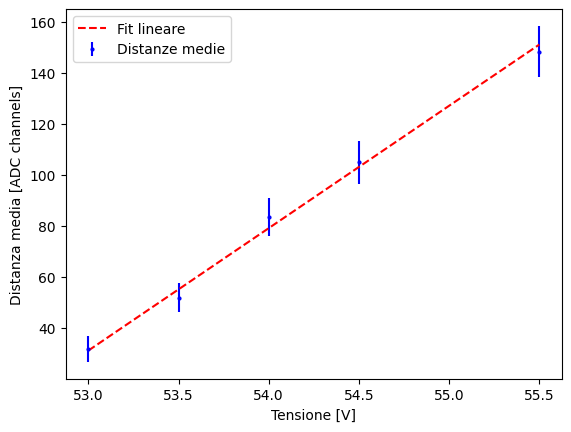

In [94]:
# Plotting the results


plt.errorbar(data_x, peaks, yerr=peaks_err, fmt='o', color='blue', markersize=2, label='Distanze medie')
plt.plot(data_x, linear(np.array(data_x), *val_lin), color='red', linestyle='--', label='Fit lineare')

plt.xlabel('Tensione [V]')
plt.ylabel('Distanza media [ADC channels]')

plt.legend()
plt.show()

In [95]:
# Calcolo della pendenza e dell'intercetta

V_b = -val_lin[1] / val_lin[0]
V_b_err = np.sqrt((err_lin[1] / val_lin[0])**2 + (val_lin[1] * err_lin[0] / val_lin[0]**2)**2)
print(f"V_b (tensione di breakdown): {V_b:.3g} ± {V_b_err:.3g} V")

V_b (tensione di breakdown): 52.4 ± 6.21 V


__Promemoria__

* Abbiamo usato le sigma delle gaussiane e per calcolare la media delle distanze e il suo errore abbiamo fatto la media pesata di ogni distanza per il relativo errore

   * Con questo metodo esce il risultato sopra

* Se avessimo usato gli errori del fit, avremmo ottenuto un Chi^2 di 800 (sottostimati errori), ma l'errore sul V_b finale sarebbe stato 0.06 circa

# ADC_Factor

In [74]:
def ADC_factor():
    return (2/50)*(1/2**12)*(4e-9)*1/25 

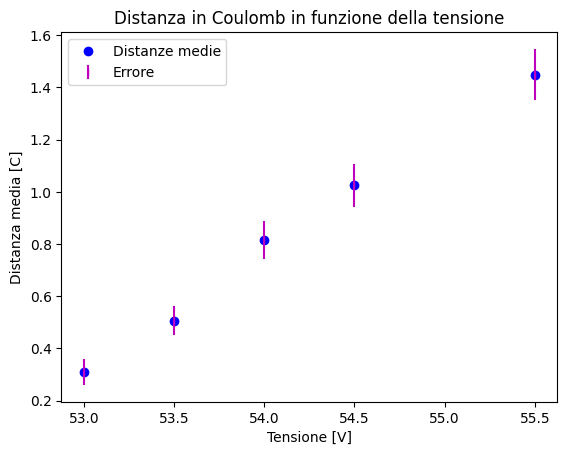

In [99]:
Dist_MeV = [ peaks[i] * ADC_factor() /1.6e-13 for i in range(len(peaks)) ]
Dist_MeV_err = [ peaks_err[i] * ADC_factor() /1.6e-13 for i in range(len(peaks)) ]

plt.plot(data_x, Dist_MeV, 'o', color='blue', label='Distanze medie')
plt.errorbar(data_x, Dist_MeV, yerr=Dist_MeV_err,fmt = '|', color='m', label='Errore')
plt.xlabel('Tensione [V]')
plt.ylabel('Distanza media [C]')
plt.title('Distanza in Coulomb in funzione della tensione')
plt.legend()
plt.show()

## Gain


In [96]:
# Calcolo del guadagno del SiPM
print(f"Gain del SiPM: {ADC_factor()/1.6e-19:.3e}")

Gain del SiPM: 9.766e+03


# Conclusioni

Abbiamo verificato l'andamento lineare tra il guadagno e la tensione, abbiamo calcolato l'ADC factor per convertire gli adc in carica.

Per trovare il $G_{psau}$ al variare della tensione, basta fare $\Delta pp \cdot \frac{ADC_{factor}}{e}$, che alla fine è solo un fattore moltiplicativo quindi il grafico è lo stesso. In totale possiamo paragonare il risultato ottenuto con quello dichiarato dal produttore ad una data tensione.